# Shorewood, WI Traffic Stop Data
This notebook plots traffic stops in the city of Shorewood, WI on a map of same.

Based on work published in the following article

>Boeing, G. 2017. [OSMnx: New Methods for Acquiring, Constructing, Analyzing, and Visualizing Complex Street Networks](http://geoffboeing.com/publications/osmnx-complex-street-networks/).” Computers, Environment and Urban Systems 65, 126-139. doi:10.1016/j.compenvurbsys.2017.05.004

and the following book

>Iliinsky, Noah P. N., and Julie Steele. Beautiful Visualization: Looking at Data through the Eyes of Experts. O'Reilly Media, 2010.

In [1]:
# Knobs and Dials
place_name = "Shorewood, Wisconsin, USA" # used to fetch the area and street maps from OpenStreetMap
data_source_file = "Copy of Sept 2019 SHPD Traffic Stops.csv" # file containing the traffic stop data
indicator_column = "Race" # name of the column containing the categories we want to plot (i.e. dot color indicator)

area_color = 'black' # background color
street_color = "#BC8F8F" # street overlay color

map_size = (20, 20) # size of map
marker_size = 100 # size of traffic stop dots

In [2]:
import pandas as pd
import geopandas
import geoplot
import re
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Data Source Metadata
primary_key = 'Call#' # unique identifier for each row
address_column = 'Location' # column containing addresses to plot
address_stopwords = ['BLK', ',LOT', ',PARK', ',BLDG'] # strings to remove from address data before geocoding
custom_address_proc = (lambda addr: re.sub(';[A-Z][A-Z]', '', addr)) # custom address preprocessing function

In [65]:
# Utility Functions
def fetch_osm_data(place_name):
    """Fetch the place data from OpenStreetMap API"""
    
    graph = ox.graph_from_place(place_name)
    area = ox.gdf_from_place(place_name)
    
    return (graph, area)

def sort_stops(stops):
    """Sort the stops into lists of stops by block number and stops by intersection"""
    
    stops_block = []
    stops_intersection = []
    
    for i in stops.index:
        stop = stops.loc[i, address_column]
        
        if stop.find('/') == -1:
            stops_block.append(stops.loc[i])
        else:
            stops_intersection.append(stops.loc[i])
    
    return pd.DataFrame(stops_block), pd.DataFrame(stops_intersection)

def prepare_lcn_data(lcn_data):
    """Preprocess location data"""
    
    for i in lcn_data.index:
        addr = lcn_data.loc[i, address_column]
        addr = custom_address_proc(addr)
        
        for word in address_stopwords:
            addr = addr.replace(word, '')
            
        lcn_data.loc[i, address_column] = addr
    
    return lcn_data

def geocode_stops_osm(stops_df):
    """Call OpenStreetMap API to geocode the traffic stops"""
    
    lcns = []
    
    for i in stops_df.index:
        print(f"Geocoding address {stops_df.loc[i, address_column]}")
        
        try:
            lcn = {}
            lcn[primary_key] = stops_df.loc[i, primary_key]
            lcn['geometry'] = ox.geocoder.geocode(stops_df.loc[i, address_column])
        except Exception as ex:
            print(f"Error: {ex}")
        finally:
            lcns.append(lcn)
        
    return lcns
    
def merge_geocoded_data(lcns, stops_df):
    """Merge the geocoded location data back into the Stops DataFrame"""
    
    # note - took me an entire afternoon to get the geocoded coords merged back into the GeoDataFrame
    # geopandas, please make this easier
    
    lcns_frame = pd.DataFrame(lcns)
    geo_column = lcns_frame['geometry'].tolist()
    lcns_frame[['x', 'y']] = pd.DataFrame(geo_column, columns=['x', 'y'])
    points = geopandas.points_from_xy(lcns_frame['y'], lcns_frame['x']) # geocoder returns backwards pairs
    lcns_gdf = geopandas.GeoDataFrame(lcns_frame, geometry=points)
    merged_frame = stops_df.merge(lcns_gdf, on=primary_key)

    # -- clean up the newly-minted GeoDataFrame --
    
    # drop unneeded columns
    for col in ['geometry_x', 'x', 'y']:
        merged_frame = merged_frame.drop(col, 1)
    
    # rename the remaining geometry column so GeoPandas recognizes it
    merged_frame = merged_frame.rename(columns={'geometry_y': 'geometry'}).set_geometry('geometry')
    
    # create summary frame
    summary_frame = merged_frame.dissolve(by=[indicator_column, address_column], aggfunc='count')
    summary_frame = summary_frame.reset_index()
    summary_frame = summary_frame[~summary_frame['geometry'].is_empty]
    
    # scale indicator size
    summary_frame['indicator_size'] = summary_frame[primary_key] * 100
    
    # sort for plot
    summary_frame = summary_frame.sort_values(by='indicator_size', ascending=False)
    
    return merged_frame, summary_frame

def plot_map(data, graph, area):
    """Draw the map using pyplt"""
    
    nodes, edges = ox.graph_to_gdfs(graph)
    fig, ax = plt.subplots(figsize=map_size)
    ax.set_aspect('equal')
    ax.set_xlim(area.loc[0].bbox_west, area.loc[0].bbox_east)
    ax.set_ylim(area.loc[0].bbox_south, area.loc[0].bbox_north)
    plt.title("Traffic stops in Shorewood, WI in September of 2019")
    
    area.plot(ax=ax, color=area_color, zorder=0)
    edges.plot(ax=ax, linewidth=1, edgecolor=street_color, zorder=1)
    data.plot(ax=ax, column=indicator_column, zorder=3, legend=True, markersize='indicator_size')

In [5]:
# load data from file
traffic_stops = geopandas.read_file(data_source_file)

In [6]:
# sort data into lists by address type
block_df, intersection_df = sort_stops(traffic_stops)

In [7]:
# For now, we are ignoring the stops_intersection list
# as none of the free geocoders support intersection lookups.
# Google Maps API v3 does but it's a paid subscription service.
# Watch the OSM Nominatim project
# (https://github.com/osm-search/Nominatim/issues/123)
# for when this gets implemented.

# preprocess data for geocoding
lcn_data = prepare_lcn_data(block_df)

In [8]:
# *Running this will take a long time because the OpenStreetMap goecoding APIs are rate-limited to prevent abuse.*

# geocode the addresses
lcns = geocode_stops_osm(lcn_data)

Geocoding address 1700 E Capitol Dr, Shorewood, WI 53211
Geocoding address 3800 N Maryland Ave, Shorewood, WI 53211
Geocoding address 3300 N Oakland Ave, WI 53211
Geocoding address 4000 N Wilson Dr, Shorewood, WI 53211
Geocoding address 3900 N Prospect Ave, Shorewood, WI 53211
Geocoding address 1900 E Capitol Dr, Shorewood, WI 53211
Geocoding address 3800 N Maryland Ave, Shorewood, WI 53211
Geocoding address 3500 N Oakland Ave, Shorewood, WI 53211
Geocoding address 3800 N Morris Blvd, Shorewood, WI 53211
Geocoding address 3500 N Oakland Ave, Shorewood, WI 53211
Geocoding address 3800 N Maryland Ave, Shorewood, WI 53211
Geocoding address 4000 N Humboldt Ave, Milwaukee, WI 53211
Geocoding address 3600 N Oakland Ave, Shorewood, WI 53211
Geocoding address 1325 E Capitol Dr, Shorewood, WI 53211
Geocoding address 2000 E Capitol Dr, Shorewood, WI 53211
Geocoding address 3900 N Morris Blvd, Shorewood, WI 53211
Geocoding address 3500 N Oakland Ave, Shorewood, WI 53211
Geocoding address 3800 N O

Geocoding address 1300 E Capitol Dr, Shorewood, WI 53211
Geocoding address 1600 E Capitol Dr, Shorewood, WI 53211
Geocoding address 100 E Capitol Dr, Glendale, WI 53212
Error: Nominatim geocoder returned no results for query "100 E Capitol Dr, Glendale, WI 53212"
Geocoding address 4000 N Bartlett Ave, Shorewood, WI 53211
Geocoding address 3900 N Oakland Ave, Shorewood, WI 53211
Geocoding address 3300 N Oakland Ave, Milwaukee, WI 53211
Geocoding address 1800 E Edgewood Ave, Shorewood, WI 53211
Geocoding address 2100 E Capitol Dr, Shorewood, WI 53211
Geocoding address 1500 E Capitol Dr, Shorewood, WI 53211
Geocoding address 4000 N Newhall St, Shorewood, WI 53211
Geocoding address 1000 E Capitol Dr, Milwaukee, WI 53211
Geocoding address 3700 N Oakland Ave, Shorewood, WI 53211
Geocoding address 1600 E Capitol Dr, Shorewood, WI 53211
Geocoding address 4000 N Wilson Dr, Shorewood, WI 53211
Geocoding address 1500 E Capitol Dr, Shorewood, WI 53211
Geocoding address 700 E. Capitol DR; Milwaukee

In [66]:
# merge geocoded addresses back into data frame
gdf, summary = merge_geocoded_data(lcns, block_df)

TypeError: sort_values() got an unexpected keyword argument 'ascening'

In [10]:
# *Running this will take a long time because the OpenStreetMap shape APIs are rate-limited to prevent abuse.*

# fetch geographic data from OpenStreetMap
graph, area = fetch_osm_data(place_name)

/home/imbrius/anaconda3/envs/geo_env/lib/python3.8/site-packages/osmnx/boundaries.py:36: UserWarning: The `boundaries` module has been deprecated and will be removed in a future relase. Use the `geocoder` module's `geocode_to_gdf` function instead.
  warnings.warn(msg)


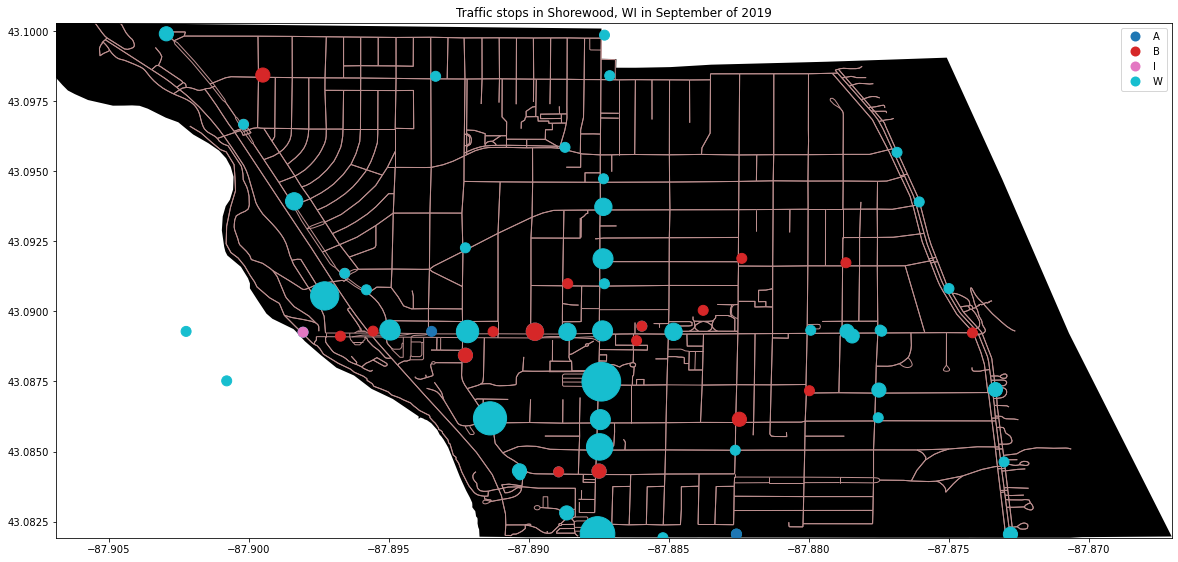

In [64]:
# finally, draw the map
plot_map(summary, graph, area)